# Exploratory Data Analysis (EDA) Notebook 📊

## Introduction 🚀

Welcome to the "Exploratory Data Analysis" (EDA) notebook (03_eda) 📈. In this notebook, we will perform a comprehensive analysis of the cleaned dataset, diving deep into various aspects of the data. We'll explore text sentiment, text length distribution, word frequencies, and more. EDA is a crucial step to gain insights and prepare the data for subsequent tasks like model building and feature engineering.

## Table of Contents 📑

- [Importing Libraries](#importing-libraries)
- [Loading Data](#loading-data)
- [Sentiment Analysis](#sentiment-analysis)
- [Descriptive Statistics](#descriptive-statistics)
- [Distribution Analysis](#distribution-analysis)
- [Filter dataset](#filter-dataset)
- [Balancing dataset](#balancing-dataset)
- [N-grams Analysis](#n-grams-analysis)
- [Data Preprocessing](#data-preprocessing)
- [Saving Processed Data](#saving-processed-data)

## Importing Libraries 📚

Let's start by importing the necessary libraries for our exploratory data analysis.


In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Optional
from typing import Any

## Loading Data 📊

We'll load the cleaned dataset that we created in the previous notebook.

In [2]:
tqdm.pandas()
pd.set_option("display.max_colwidth", None)

parquet_file_path = "./../data/intermediate_data/clean_dataset.br"
df = pd.read_parquet(parquet_file_path, engine="pyarrow")

## Sentiment Analysis 📝

Let's perform sentiment analysis on a sample of the dataset to understand the distribution of sentiment.

In [3]:
SAMPLE_SIZE = 10_000
sample_df = df.sample(SAMPLE_SIZE, random_state=42).drop("text", axis=1)
sample_df["polarity"] = sample_df["clean_text"].progress_apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)
sample_df.head()

100%|██████████| 10000/10000 [00:06<00:00, 1498.15it/s]


,clean_text,polarity
712626,frowning face nowplaying bad feat rihanna remix by on anghami,-0.7000
21935,floor test tomorrow nomination anglo indian assembly yedduyurappa must not make any major policy decisions meanwhile supremecourt,0.0625
324532,sp has regularly lied to people about our proposal not getting past the clerks we are meant to believe that having torpedoed it with mps lcag then put our settlement proposal forward steve still does not seem to grasp the idea was to change the law not ask hmrc for concessions,-0.1250
566900,why do you keep watching at this point anyone watching television is the problem,0.0000
764931,i am not no criminal baby dismiss me you are not got to keep bringing me back i am joking hete,0.1000


Using `polarity_class` function we can classify polarity scores into "positive," "negative," or "neutral.

In [4]:
def polarity_class(polarity: float) -> str:
    """
    Classify polarity scores into "positive," "negative," or "neutral."

    Args:
        polarity (float): The polarity score to be classified.

    Returns:
        str: The polarity class, which can be "positive," "negative," or "neutral."
    """
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

In [5]:
sample_df["sentiment"] = sample_df["polarity"].progress_apply(
    lambda x: polarity_class(x)
)
sample_df.head()

100%|██████████| 10000/10000 [00:00<00:00, 113631.98it/s]


,clean_text,polarity,sentiment
712626,frowning face nowplaying bad feat rihanna remix by on anghami,-0.7000,negative
21935,floor test tomorrow nomination anglo indian assembly yedduyurappa must not make any major policy decisions meanwhile supremecourt,0.0625,positive
324532,sp has regularly lied to people about our proposal not getting past the clerks we are meant to believe that having torpedoed it with mps lcag then put our settlement proposal forward steve still does not seem to grasp the idea was to change the law not ask hmrc for concessions,-0.1250,negative
566900,why do you keep watching at this point anyone watching television is the problem,0.0000,neutral
764931,i am not no criminal baby dismiss me you are not got to keep bringing me back i am joking hete,0.1000,positive


We also apply `text_length` to find the length of the text

In [6]:
sample_df['text_length'] = sample_df['clean_text'].progress_apply(lambda x: len(str(x).split()))

100%|██████████| 10000/10000 [00:00<00:00, 47246.03it/s]


## Descriptive Statistics 📈
We'll compute descriptive statistics for the numerical attributes, including polarity and text length.

In [7]:
def describe_categorical(
    df: pd.DataFrame,
    columns: list[str] = None,
    n: int = 25,
    include_missing: bool = True,
) -> pd.DataFrame:
    """
    Generate descriptive statistics for categorical columns in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        columns (list[str], optional): A list of column names to analyze. If empty, all categorical columns are analyzed. Defaults to [].
        n (int, optional): The maximum number of unique values to show for each category. Defaults to 25.
        include_missing (bool, optional): Include missing (NaN) values in the statistics. Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame containing descriptive statistics for the categorical columns.
    """
    if columns is None:
        columns = []
    if columns is None:
        columns = df.select_dtypes(include=["category"]).columns.tolist()
    stats = pd.DataFrame(columns=["count", "percentage"])
    total = df.shape[0]
    for col in columns:
        if include_missing:
            values, counts = (
                df[col].value_counts(dropna=False).index.tolist(),
                df[col].value_counts(dropna=False).values.tolist(),
            )
        else:
            values, counts = (
                df[col].value_counts().index.tolist(),
                df[col].value_counts().values.tolist(),
            )
        if n is not None:
            values = values[:n]
            counts = counts[:n]
        stats_col = pd.DataFrame(
            {"column": col, "value": values, "count": counts}
        )
        stats_col["percentage"] = stats_col["count"] / total * 100
        stats = pd.concat([stats, stats_col], ignore_index=False)
    stats.set_index(["column", "value", "count", "percentage"], inplace=True)
    return stats.sort_index()

In [8]:
def plot_graph_categorical(data: pd.Series) -> None:
    """
    Create univariate analysis plots (bar plot and pie chart) for a categorical variable.

    Args:
        data (pd.Series): A Pandas Series containing categorical data.
    """
    # Count the frequency of each unique value in the categorical data
    values, counts = np.unique(data, return_counts=True)
    sorted_idx = np.argsort(-counts)
    values = values[sorted_idx]
    counts = counts[sorted_idx]

    # Create subplots for the bar plot and pie chart
    f, (ax_bar, ax_pie) = plt.subplots(1, 2)

    # Create a count plot (bar plot)
    sns.countplot(
        x=data, ax=ax_bar, order=data.value_counts().index, palette="viridis"
    )
    ax_bar.set(xlabel=data.name, ylabel="Count", title=f"Count by {data.name}")
    for i in ax_bar.containers:
        ax_bar.bar_label(i)

    # Create a pie chart
    color_palette = sns.color_palette("viridis", len(values)).as_hex()
    plt.title(f"Distribution by {data.name}")
    ax_pie = plt.pie(
        counts,
        labels=values,
        startangle=90,
        counterclock=False,
        autopct="%.0f%%",
        colors=color_palette,
    )

    # Set the title and adjust the figure size
    f.suptitle(f"Univariate Analysis of the {data.name} Variable")
    f.set_figwidth(20)
    f.set_figheight(10)
    
    # Ensure a tight layout and display the plots
    plt.tight_layout()
    plt.show()


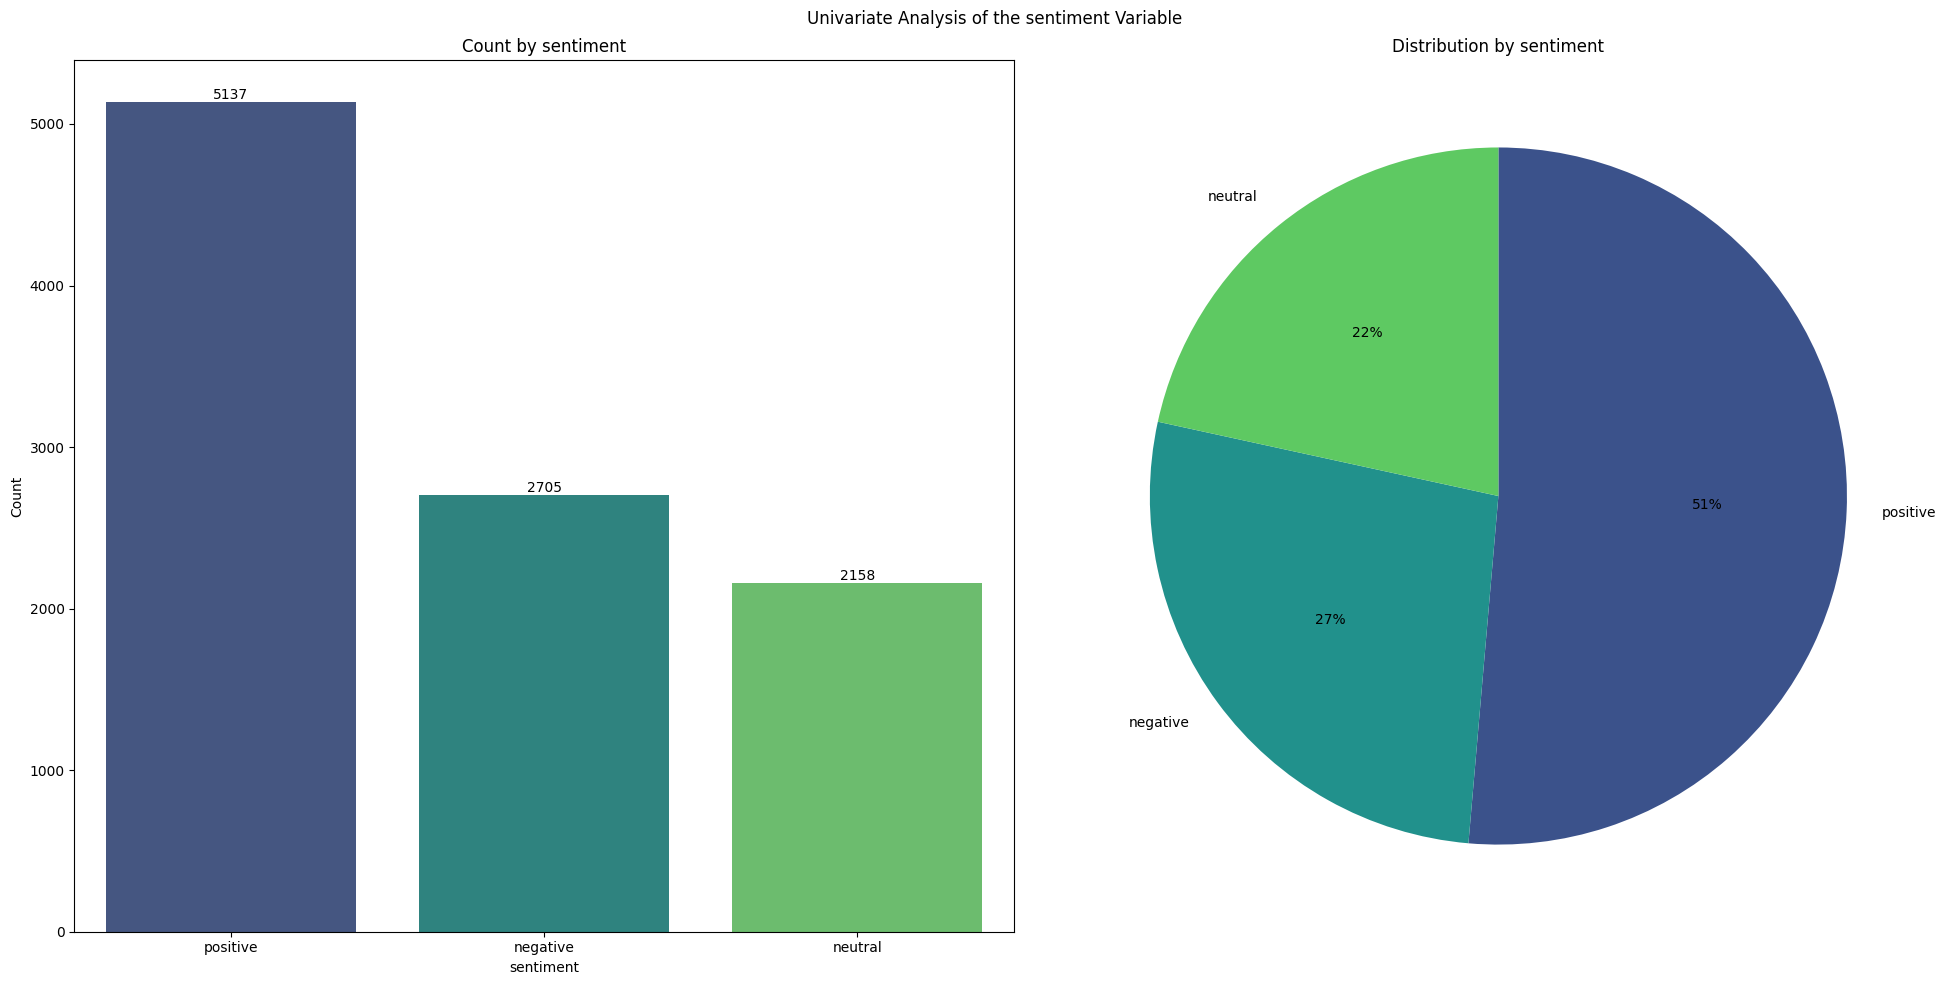

Empty DataFrame
Columns: []
Index: [(sentiment, negative, 2705, 27.05), (sentiment, neutral, 2158, 21.58), (sentiment, positive, 5137, 51.370000000000005)]

In [9]:
plot_graph_categorical(sample_df['sentiment'])
describe_categorical(sample_df, ['sentiment'])

**Insights 💡**

These insights provide an overview of the sentiment distribution in the analyzed dataset. It appears that the majority of sentiments are positive, accounting for more than half of the total sentiments, while negative and neutral sentiments make up smaller portions of the dataset.

## Distribution Analysis 📊
Let's analyze the distribution of text length and perform further analysis based on sentiment.

In [10]:
def describe_numerical(data: pd.Series) -> pd.DataFrame:
    """
    Generate descriptive statistics for numerical data in a DataFrame.

    Args:
        data (pd.Series): A Pandas Series containing numerical data.

    Returns:
        pd.DataFrame: A DataFrame containing descriptive statistics.
    """
    # Calculate basic statistics using the describe method
    stats = data.describe()

    # Calculate and add variance to the statistics
    stats.loc["var"] = data.var().tolist()

    # Calculate and add skewness to the statistics
    stats.loc["skew"] = data.skew().tolist()

    # Calculate and add kurtosis to the statistics
    stats.loc["kurtosis"] = data.kurtosis().tolist()

    # Calculate and add the range to the statistics
    stats.loc["range"] = stats.loc["max"] - stats.loc["min"]

    # Calculate and add the interquartile range (IOR) to the statistics
    stats.loc["IOR"] = stats.loc["75%"] - stats.loc["25%"]

    # Calculate and add lower and upper bounds for potential outliers
    stats.loc["lower_bound"] = stats.loc["25%"] - 1.5 * stats.loc["IOR"]
    stats.loc["upper_bound"] = stats.loc["75%"] + 1.5 * stats.loc["IOR"]

    # Identify potential outliers
    outliers = (data < stats.loc["lower_bound"]) | (data > stats.loc["upper_bound"])

    # Calculate and add the count of outliers to the statistics
    outliers_count = outliers.sum()
    stats.loc["outliers"] = outliers_count.tolist()

    return stats


In [11]:
def plot_graph_numerical(data: pd.Series) -> None:
    """
    Generate a set of three subplots for visualizing numerical data.

    Args:
        data (pd.Series): A Pandas Series containing numerical data.
    """
    # Create subplots for box plot, violin plot, and histogram
    f, (ax_box, ax_violin, ax_hist) = plt.subplots(3, sharex=True)

    # Create a box plot
    sns.boxplot(x=data, ax=ax_box, palette="viridis")
    _setup(ax_box, "Box Plot", data)

    # Create a violin plot
    sns.violinplot(x=data, ax=ax_violin, palette="viridis")
    _setup(ax_violin, "Violin Plot", data)

    # Create a histogram with a density plot (kernel density estimate)
    sns.histplot(x=data, kde=True, ax=ax_hist, color="#21918c")
    _setup(ax_hist, "Histogram + Density Plot", data)

    # Set the figure size
    f.set_figwidth(20)
    f.set_figheight(10)

    # Add a title to the entire figure
    f.suptitle(f"Univariate Analysis of the {data.name} Variable")

    # Ensure tight layout for better visualization
    plt.tight_layout()

    # Display the plots
    plt.show()


def _setup(ax: Any, title: str, data: pd.Series) -> None:
    """
    Set common properties for a subplot in a Matplotlib figure.

    Args:
        ax (matplotlib.axes.Axes): The subplot to configure.
        title (str): The title for the subplot.
        data (pd.Series): A Pandas Series containing data.
    """
    # Set the title of the subplot
    ax.set_title(title)

    # Set the label for the x-axis (horizontal axis)
    ax.set_xlabel(f"{data.name}")

    # Set the label for the y-axis (vertical axis)
    ax.set_ylabel("Value")


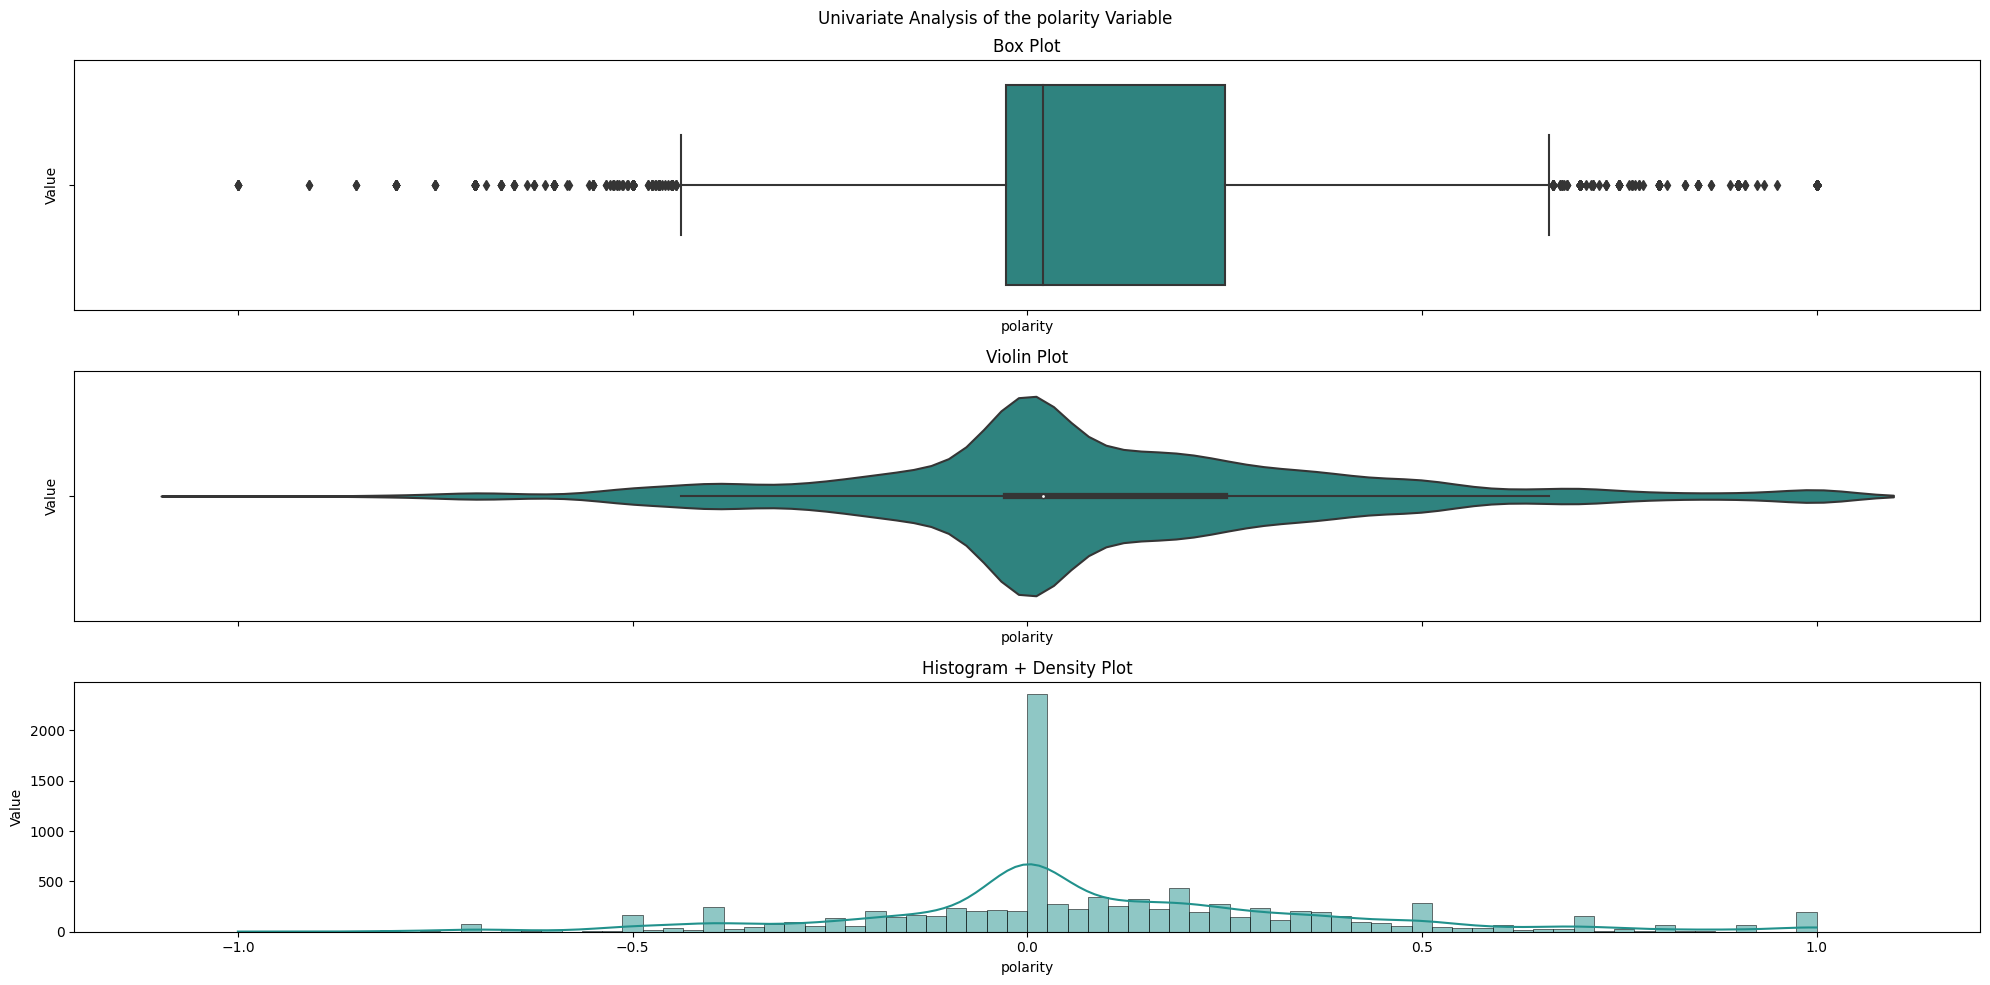

count          10000.000000
mean               0.094767
std                0.307287
min               -1.000000
25%               -0.026250
50%                0.020000
75%                0.250000
max                1.000000
var                0.094425
skew               0.415190
kurtosis           1.161208
range              2.000000
IOR                0.276250
lower_bound       -0.440625
upper_bound        0.664375
outliers         952.000000
Name: polarity, dtype: float64

In [12]:
plot_graph_numerical(sample_df['polarity'])
describe_numerical(sample_df['polarity'])

**Insights 💡**

These statistics provide insights into the distribution and characteristics of the "polarity" data. For example, the mean polarity is approximately 0.095, with a standard deviation of 0.307, indicating some variability in the data. The data ranges from -1 to 1, with a median value of 0.02. The presence of outliers (952 in total) suggests that there may be extreme values in the dataset.


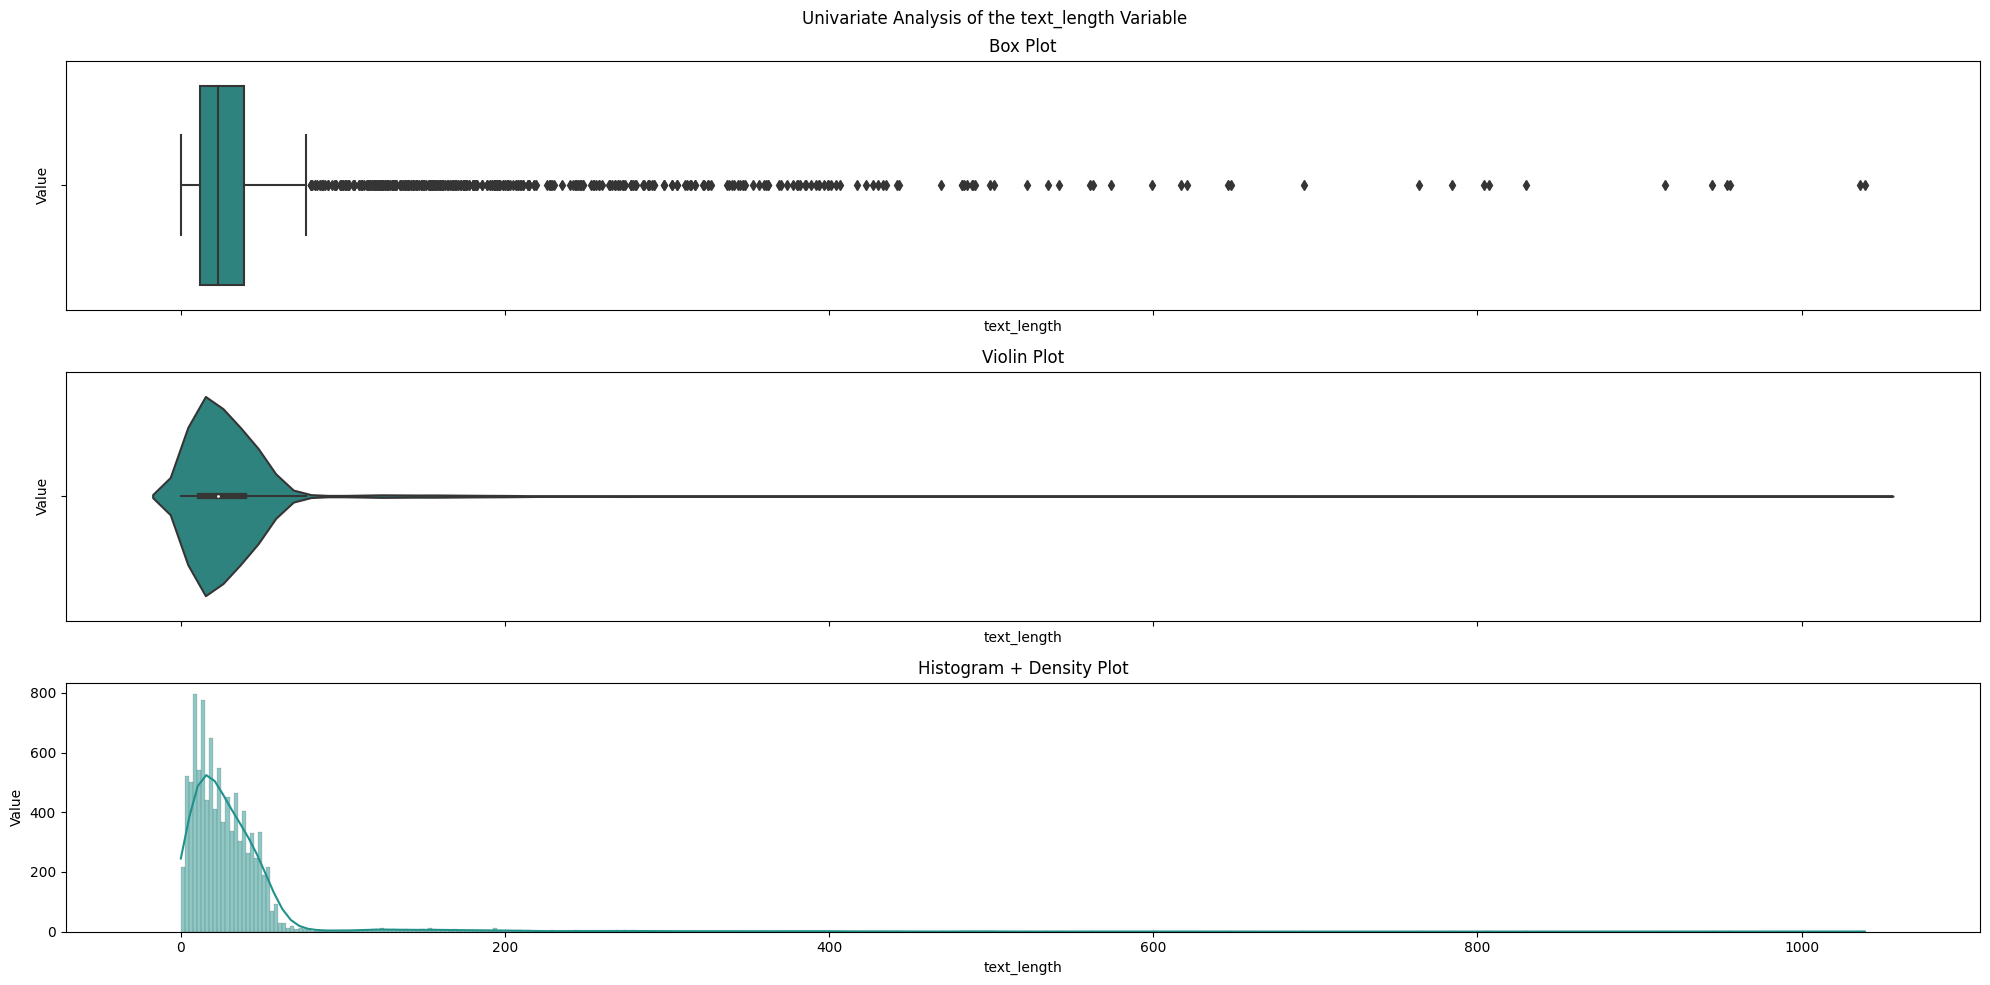

count          10000.000000
mean              33.515600
std               54.841961
min                0.000000
25%               12.000000
50%               23.000000
75%               39.000000
max             1039.000000
var             3007.640721
skew               8.275135
kurtosis          97.938294
range           1039.000000
IOR               27.000000
lower_bound      -28.500000
upper_bound       79.500000
outliers         405.000000
Name: text_length, dtype: float64

In [13]:
plot_graph_numerical(sample_df['text_length'])
describe_numerical(sample_df['text_length'])

**Insights 💡**

These statistics provide insights into the distribution and characteristics of the "text_length" data. For instance, the mean text length is approximately 33.52, but the data is highly right-skewed (Skewness = 8.275), with a large standard deviation (Std = 54.842). The presence of outliers (405 in total) and a high kurtosis value (Kurtosis = 97.938) suggest that the data has a long tail with extreme values.


In [14]:
def describe_categorical_grouped(
    df: pd.DataFrame, group_col: list[str], col: str
) -> pd.DataFrame:
    """
    Calculate statistics for a numerical column grouped by a categorical column.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        group_col (str): The name of the categorical column for grouping.
        col (str): The name of the numerical column for which statistics are calculated.

    Returns:
        pd.DataFrame: A DataFrame containing various statistics for the grouped data.
    """
    # Calculate basic statistics for the numerical column grouped by the categorical column
    group_stats = df.groupby(group_col)[col].describe()

    # Calculate variance for the grouped data and add it to the result
    group_stats = group_stats.join(
        pd.DataFrame(
            df.groupby(group_col)[col].var().tolist(),
            columns=["var"],
            index=group_stats.index,
        )
    )

    # Calculate skewness for the grouped data and add it to the result
    group_stats = group_stats.join(
        pd.DataFrame(
            df.groupby(group_col)[col].skew().tolist(),
            columns=["skew"],
            index=group_stats.index,
        )
    )

    # Calculate kurtosis for the grouped data and add it to the result
    group_stats = group_stats.join(
        pd.DataFrame(
            df.groupby(group_col)[col].apply(pd.DataFrame.kurt).tolist(),
            columns=["kurtosis"],
            index=group_stats.index,
        )
    )

    # Calculate range for the grouped data and add it to the result
    group_stats = group_stats.join(
        pd.DataFrame(
            (group_stats["max"].values - group_stats["min"].values).tolist(),
            columns=["range"],
            index=group_stats.index,
        )
    )

    # Calculate Interquartile Range (IOR) for the grouped data and add it to the result
    group_stats = group_stats.join(
        pd.DataFrame(
            (group_stats["75%"].values - group_stats["25%"].values).tolist(),
            columns=["IOR"],
            index=group_stats.index,
        )
    )

    # Calculate lower bound for outliers and add it to the result
    group_stats = group_stats.join(
        pd.DataFrame(
            (
                group_stats["25%"].values - 1.5 * group_stats["IOR"].values
            ).tolist(),
            columns=["lower_bound"],
            index=group_stats.index,
        )
    )

    # Calculate upper bound for outliers and add it to the result
    group_stats = group_stats.join(
        pd.DataFrame(
            (
                group_stats["75%"].values + 1.5 * group_stats["IOR"].values
            ).tolist(),
            columns=["upper_bound"],
            index=group_stats.index,
        )
    )

    # Calculate the number of outliers for each group and add it to the result
    outliers = (
        df.groupby(group_col, group_keys=True)[col]
        .apply(
            lambda x: (
                x
                < x.quantile(0.25)
                - 1.5 * (x.quantile(0.75) - x.quantile(0.25))
            )
            | (
                x
                > x.quantile(0.75)
                + 1.5 * (x.quantile(0.75) - x.quantile(0.25))
            )
        )
        .groupby(group_col, group_keys=True)
        .sum()
    )
    group_stats = group_stats.join(
        pd.DataFrame(
            (outliers.values).tolist(),
            columns=["outliers"],
            index=group_stats.index,
        )
    )

    return group_stats

In [15]:
def groupby_violinplot(
    df: pd.DataFrame,
    x: str,
    y: str,
    hue: Optional[str] = None,
    order: Optional[list] = None,
):
    """
    Generate a grouped violin plot to visualize the distribution of a numerical variable.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        x (str): The name of the categorical variable used for grouping.
        y (str): The name of the numerical variable to be visualized.
        hue (str, optional): The name of an additional categorical variable for further division. Defaults to None.
        order (list, optional): The order in which categories of 'x' should be displayed. Defaults to None.
    """
    # Set the figure size
    plt.figure(figsize=(15, 8))

    # Generate the violin plot
    sns.violinplot(data=df, x=x, y=y, hue=hue, order=order, palette="viridis")

    # Set the title of the plot
    plt.title(f"Distribution of {y} by {x}")

    # Display the plot
    plt.show()

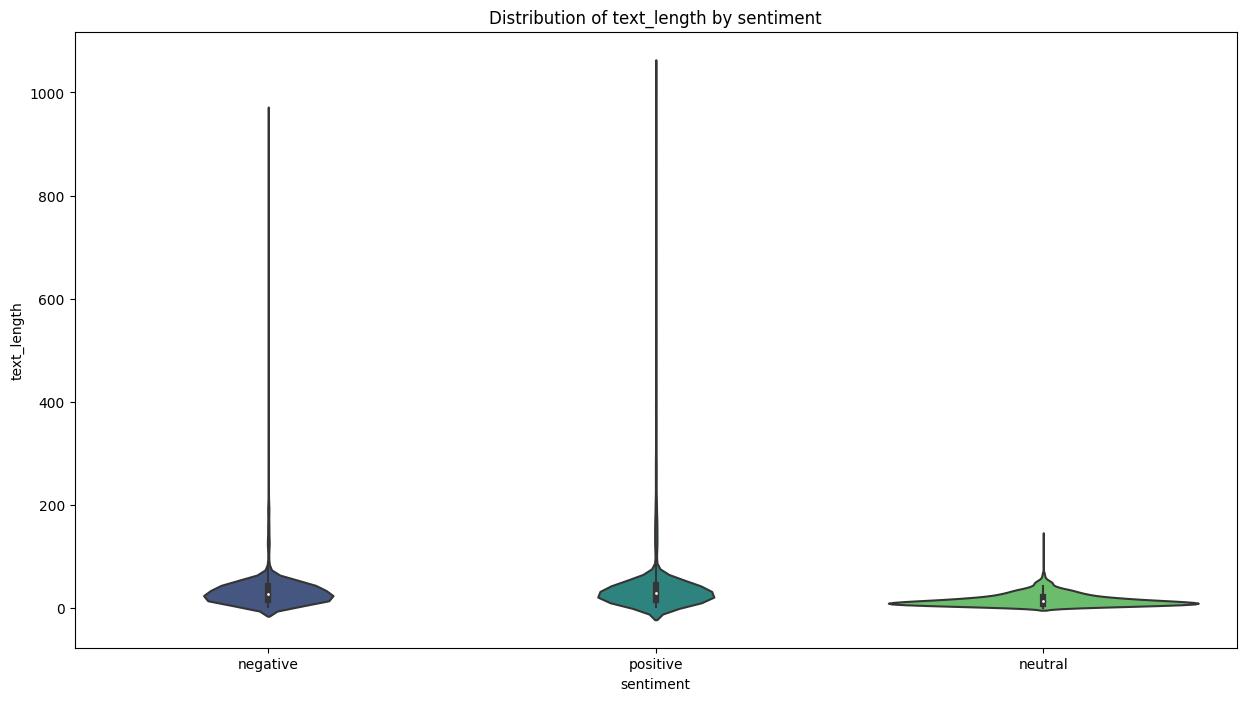

,count,mean,std,min,25%,50%,75%,max,var,skew,kurtosis,range,IOR,lower_bound,upper_bound,outliers
sentiment,,,,,,,,,,,,,,,,
negative,2705.0,33.682440,43.192891,1.0,15.0,27.0,41.0,954.0,1865.625819,8.854561,124.486231,953.0,26.0,-24.0,80.0,89
neutral,2158.0,15.482391,12.051636,0.0,7.0,12.0,21.0,140.0,145.241924,1.705150,6.499483,140.0,14.0,-14.0,42.0,81
positive,5137.0,41.003309,67.966687,1.0,15.0,28.0,43.0,1039.0,4619.470589,6.950047,66.254855,1038.0,28.0,-27.0,85.0,310


In [16]:
groupby_violinplot(sample_df, "sentiment", "text_length")
describe_categorical_grouped(sample_df, ["sentiment"], "text_length")

**Insights 💡**

These statistics provide insights into the distribution and characteristics of the "text_length" data for each sentiment category. It's evident that the three categories have different means, variances, and distributions, with the positive sentiment category having the highest mean and the negative sentiment category having the highest kurtosis and skewness values, indicating a more skewed and peaked distribution.


In [17]:
def generate_jointplot(
    data,
    x,
    y,
    hue=None,
    palette="viridis",
    title=None,
    vertical_line=None,
    horizontal_line=None,
):
    """
    Generate a joint plot with optional vertical and horizontal dotted lines.

    Args:
        data: The DataFrame containing the data.
        x: The name of the column for the x-axis.
        y: The name of the column for the y-axis.
        hue: The name of the column to differentiate by color (optional).
        palette: The color palette to use (default is "viridis").
        title: The title of the plot (optional).
        vertical_line: The x-coordinate of the vertical dotted line (optional).
        horizontal_line: The y-coordinate of the horizontal dotted line (optional).
    """
    kdeplot = sns.jointplot(data=data, x=x, y=y, hue=hue, palette=palette)

    # Add vertical and horizontal dotted lines if specified
    if vertical_line is not None:
        kdeplot.ax_joint.axvline(x=vertical_line, linestyle="--", color="grey")
    if horizontal_line is not None:
        kdeplot.ax_joint.axhline(
            y=horizontal_line, linestyle="--", color="grey"
        )

    # Set the plot title if specified
    if title is not None:
        plt.suptitle(title, y=1)

    plt.show()

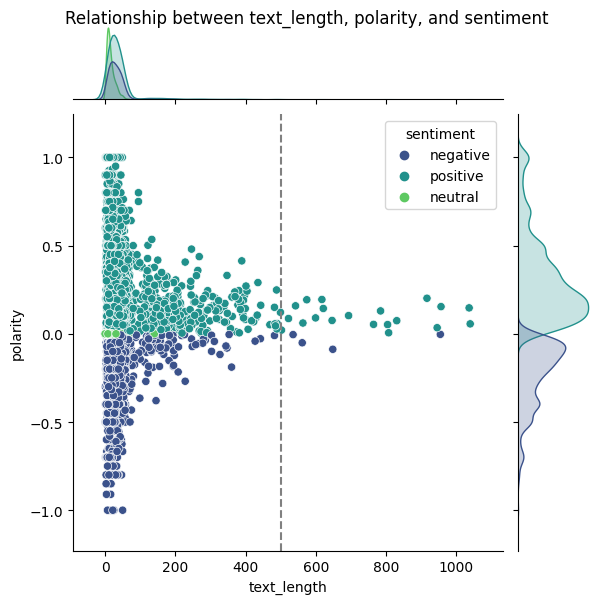

In [18]:
generate_jointplot(
    sample_df,
    "text_length",
    "polarity",
    hue="sentiment",
    title="Relationship between text_length, polarity, and sentiment",
    vertical_line=500,
)

In [19]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 712626 to 519920
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   clean_text   10000 non-null  object 
 1   polarity     10000 non-null  float64
 2   sentiment    10000 non-null  object 
 3   text_length  10000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 390.6+ KB


## Filter dataset

We can drop the text that are null or greater then 500 length

In [20]:
filtered_df = sample_df[
    (sample_df["text_length"] != 0) & (sample_df["text_length"] < 500)
]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9930 entries, 712626 to 519920
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   clean_text   9930 non-null   object 
 1   polarity     9930 non-null   float64
 2   sentiment    9930 non-null   object 
 3   text_length  9930 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 387.9+ KB


Now applying statices to updated dataset

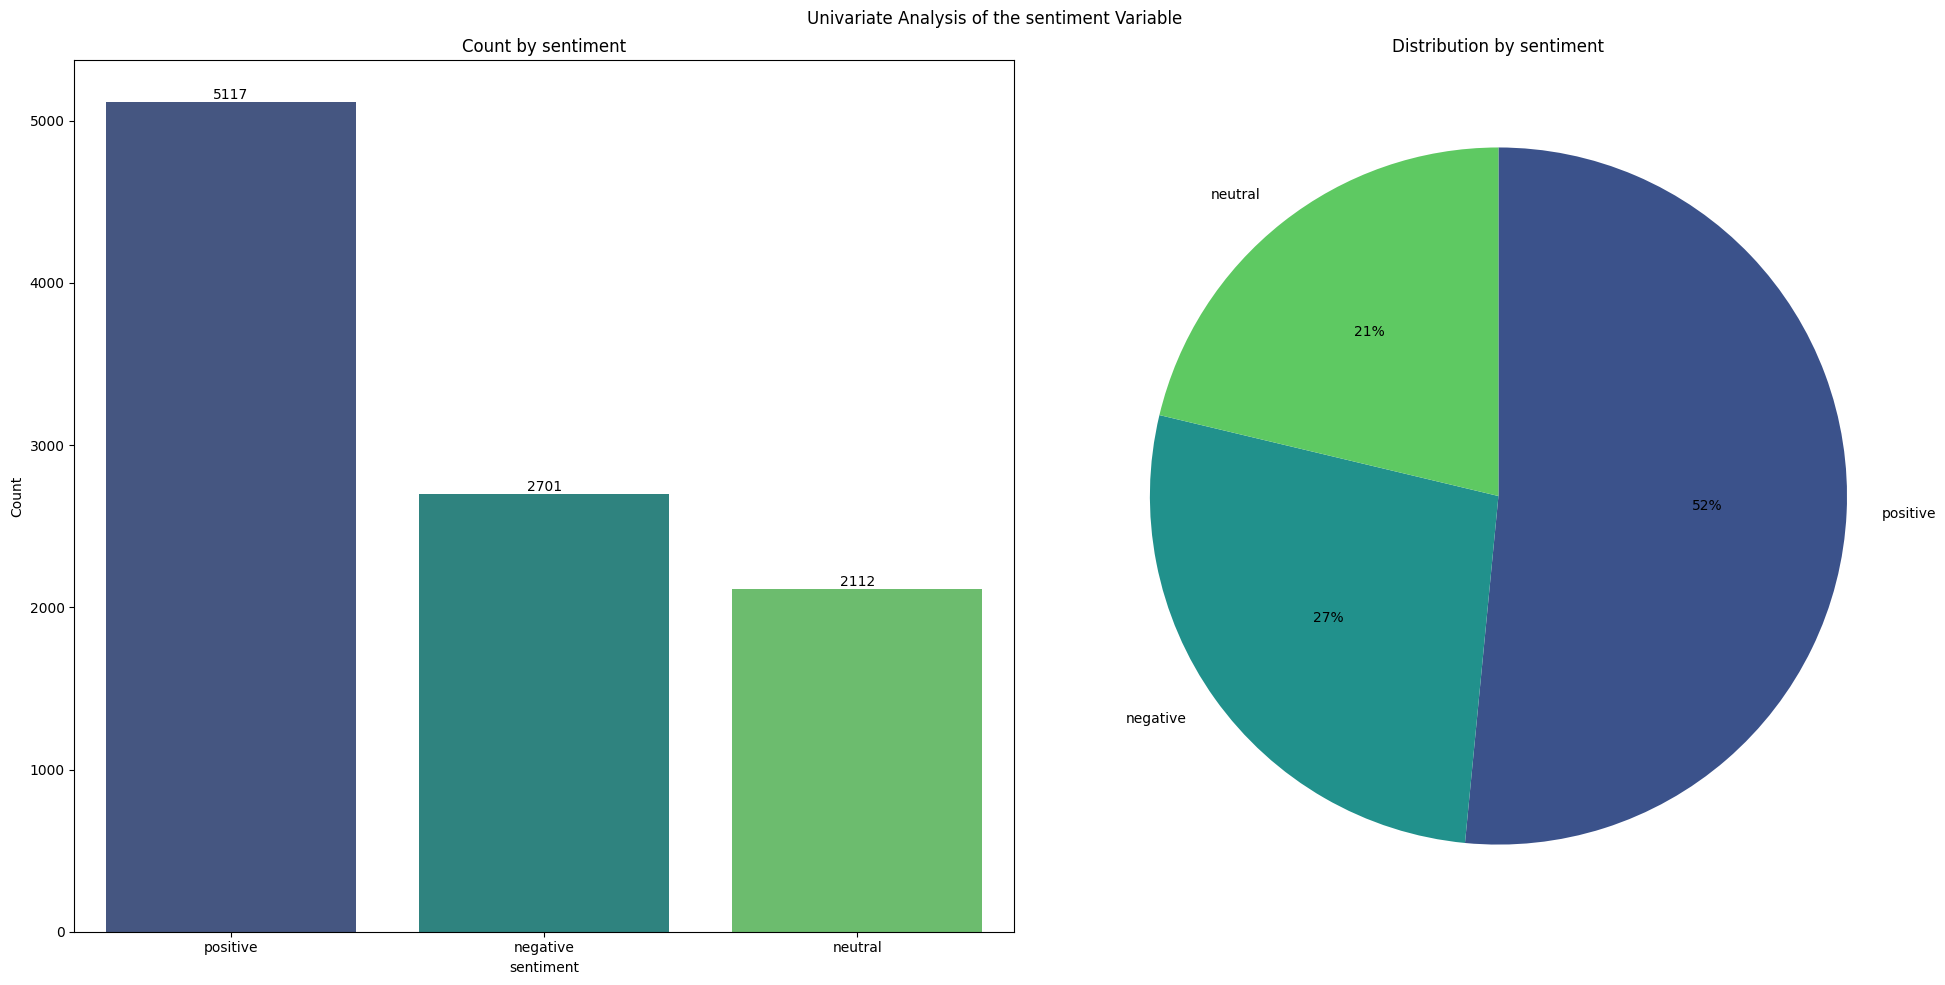

Empty DataFrame
Columns: []
Index: [(sentiment, negative, 2701, 27.200402819738166), (sentiment, neutral, 2112, 21.268882175226587), (sentiment, positive, 5117, 51.53071500503524)]

In [21]:
plot_graph_categorical(filtered_df['sentiment'])
describe_categorical(filtered_df, ['sentiment'])

**Insights 💡**

These insights provide an overview of the sentiment distribution in the analyzed dataset. It appears that the majority of sentiments are positive, accounting for more than half of the total sentiments, while negative and neutral sentiments make up smaller portions of the dataset.


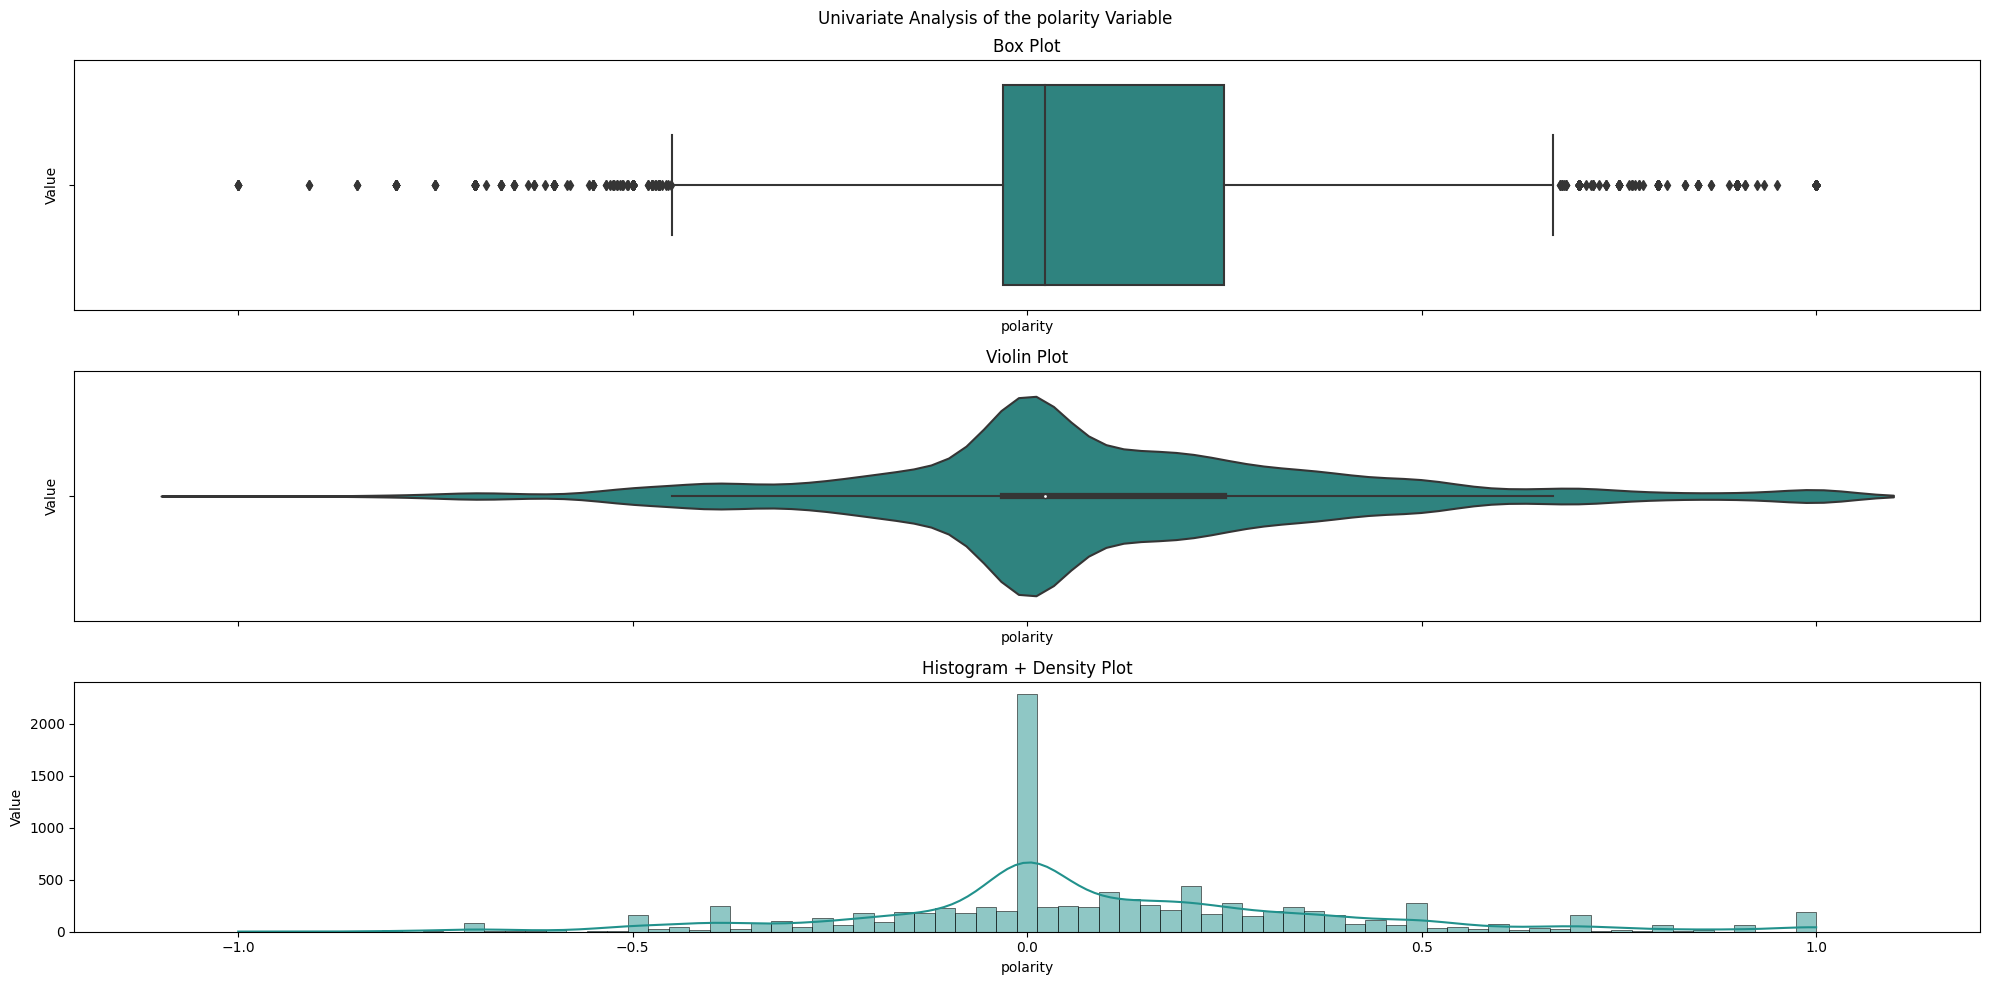

count          9930.000000
mean              0.095245
std               0.308277
min              -1.000000
25%              -0.030459
50%               0.022619
75%               0.250000
max               1.000000
var               0.095035
skew              0.409618
kurtosis          1.134353
range             2.000000
IOR               0.280459
lower_bound      -0.451148
upper_bound       0.670689
outliers        906.000000
Name: polarity, dtype: float64

In [22]:
plot_graph_numerical(filtered_df['polarity'])
describe_numerical(filtered_df['polarity'])

**Insights 💡**

These statistics provide insights into the distribution and characteristics of the "polarity" data. For example, the mean polarity is approximately 0.095, with a standard deviation of 0.308, indicating some variability in the data. The data ranges from -1 to 1, with a median value of 0.022619. The presence of outliers (906 in total) suggests that there may be extreme values in the dataset.


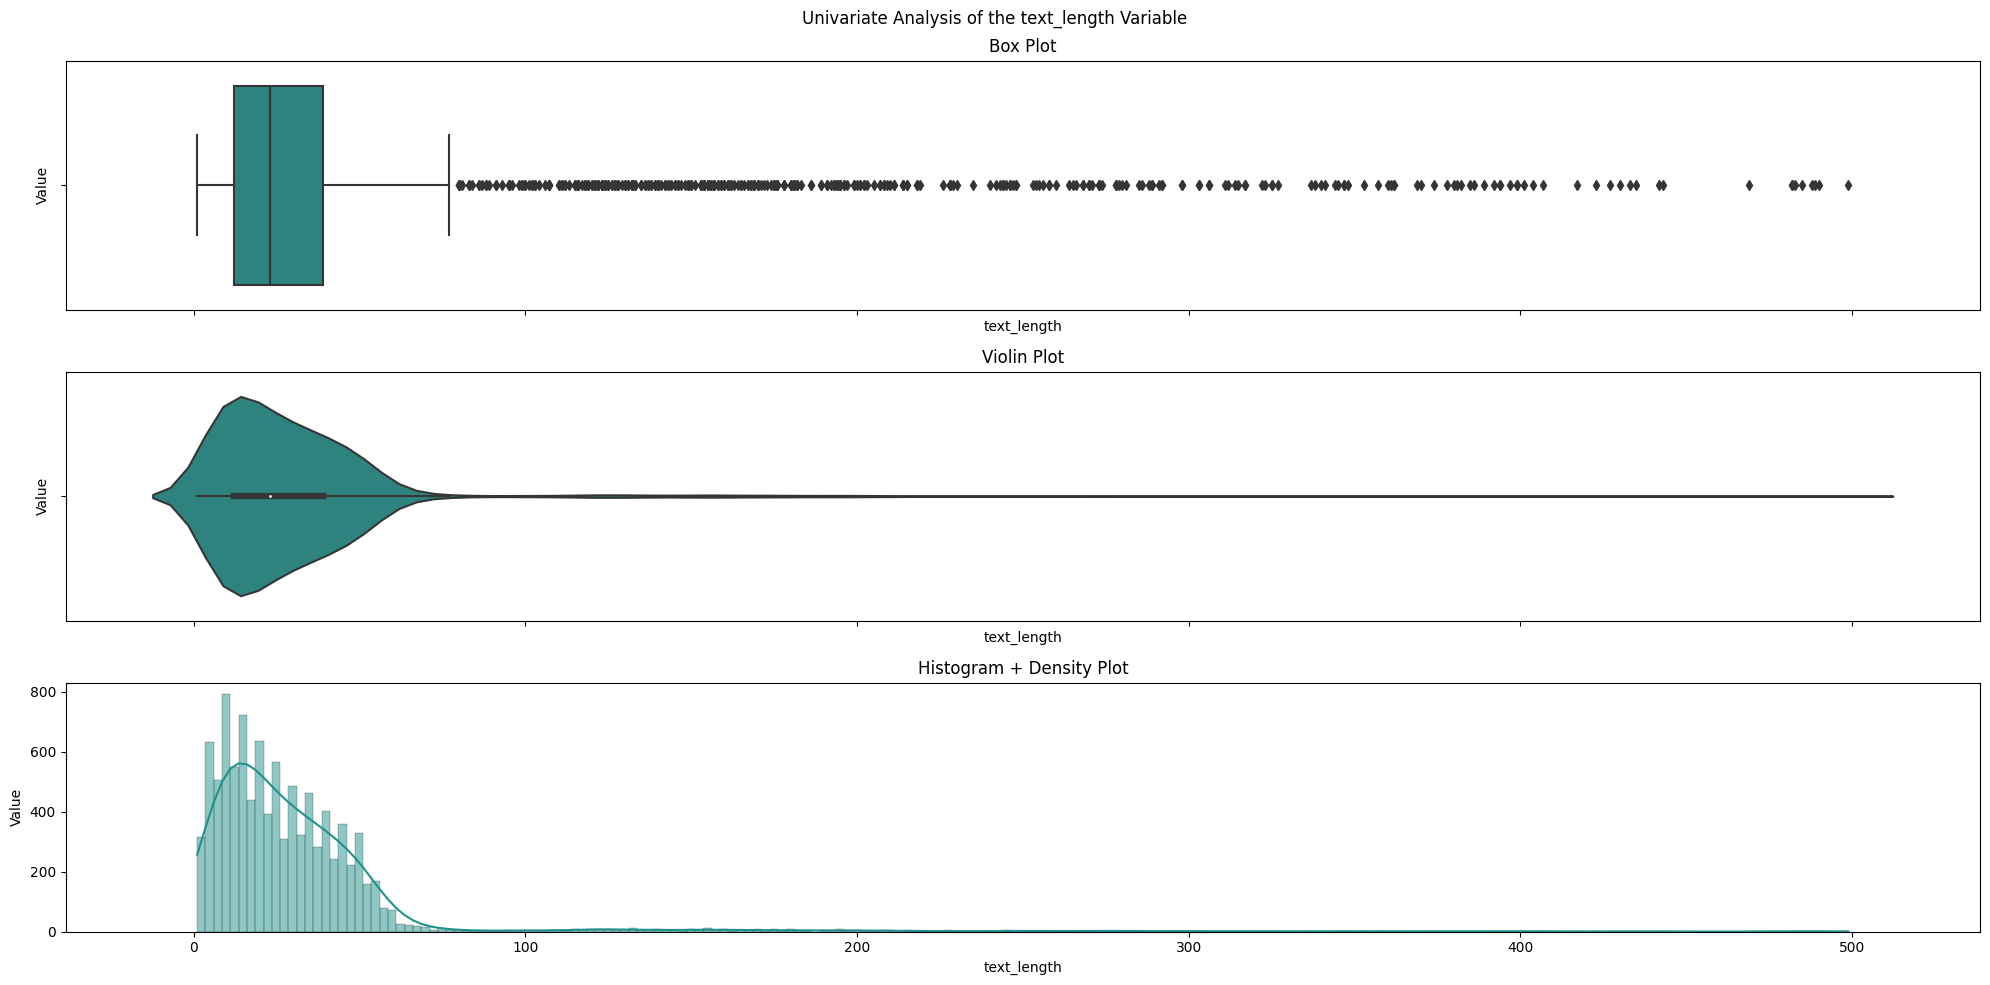

count          9930.000000
mean             31.993756
std              42.269073
min               1.000000
25%              12.000000
50%              23.000000
75%              39.000000
max             499.000000
var            1786.674551
skew              5.596612
kurtosis         40.494045
range           498.000000
IOR              27.000000
lower_bound     -28.500000
upper_bound      79.500000
outliers        381.000000
Name: text_length, dtype: float64

In [23]:
plot_graph_numerical(filtered_df['text_length'])
describe_numerical(filtered_df['text_length'])

**Insights 💡**

These statistics provide insights into the distribution and characteristics of the "text_length" data. For example, the mean text length is approximately 31.99, with a standard deviation of 42.27, indicating a wide variation in text lengths. The data ranges from 1 to 499, with a median value of 23. The presence of outliers (381 in total) and a high kurtosis value (Kurtosis = 40.494) suggest that the data has a long tail with extreme values.


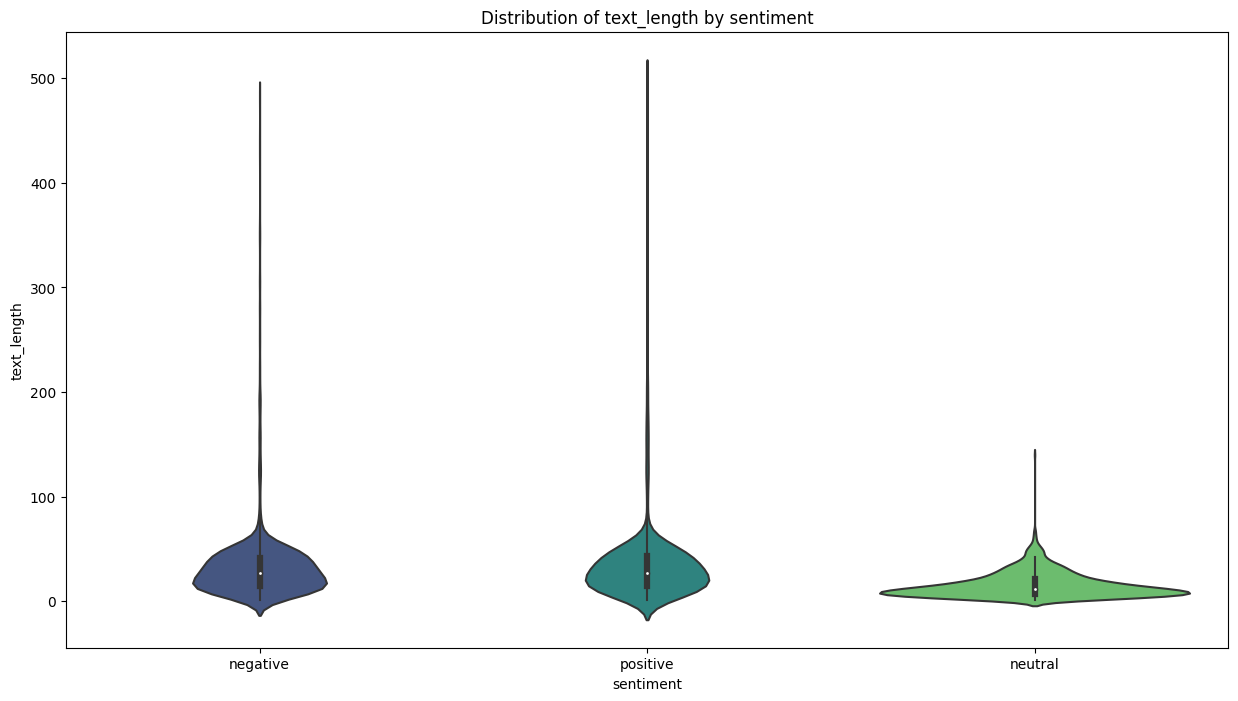

,count,mean,std,min,25%,50%,75%,max,var,skew,kurtosis,range,IOR,lower_bound,upper_bound,outliers
sentiment,,,,,,,,,,,,,,,,
negative,2701.0,32.733432,34.899146,1.0,15.0,27.0,41.0,482.0,1217.950397,5.697066,46.887507,481.0,26.0,-24.0,80.0,85
neutral,2112.0,15.819602,11.961177,1.0,7.0,12.0,21.0,140.0,143.069762,1.744793,6.740938,139.0,14.0,-14.0,42.0,81
positive,5117.0,38.279070,51.165603,1.0,15.0,27.0,43.0,499.0,2617.918977,4.815443,28.113213,498.0,28.0,-27.0,85.0,290


In [24]:
groupby_violinplot(filtered_df, "sentiment", "text_length")
describe_categorical_grouped(filtered_df, ["sentiment"], "text_length")

**Insights 💡**

These statistics provide insights into the distribution and characteristics of the "text_length" data for each sentiment category. It's evident that the three categories have different means, variances, and distributions, with the positive sentiment category having the highest mean and the negative sentiment category having the highest kurtosis and skewness values, indicating a more skewed and peaked distribution.


## Balancing dataset

Since our dataset is unbalance, we will balance our dataset using oversampling.

In [25]:
positive_df = filtered_df[filtered_df['sentiment'] == 'positive']
neutral_df = filtered_df[filtered_df['sentiment'] == 'neutral']
negative_df = filtered_df[filtered_df['sentiment'] == 'negative']  

In [26]:
SAMPLE_SIZE = positive_df.shape[0]

sample_positive_df = positive_df.sample(
    SAMPLE_SIZE, random_state=42, replace=True
)
sample_neutral_df = neutral_df.sample(
    SAMPLE_SIZE, random_state=42, replace=True
)
sample_negative_df = negative_df.sample(
    SAMPLE_SIZE, random_state=42, replace=True
)

balance_df = pd.concat(
    [sample_positive_df, sample_neutral_df, sample_negative_df]
)

## N-grams Analysis 🔍

We'll perform an analysis of the most common n-grams (unigrams, bigrams, trigrams, etc.) in the text data.

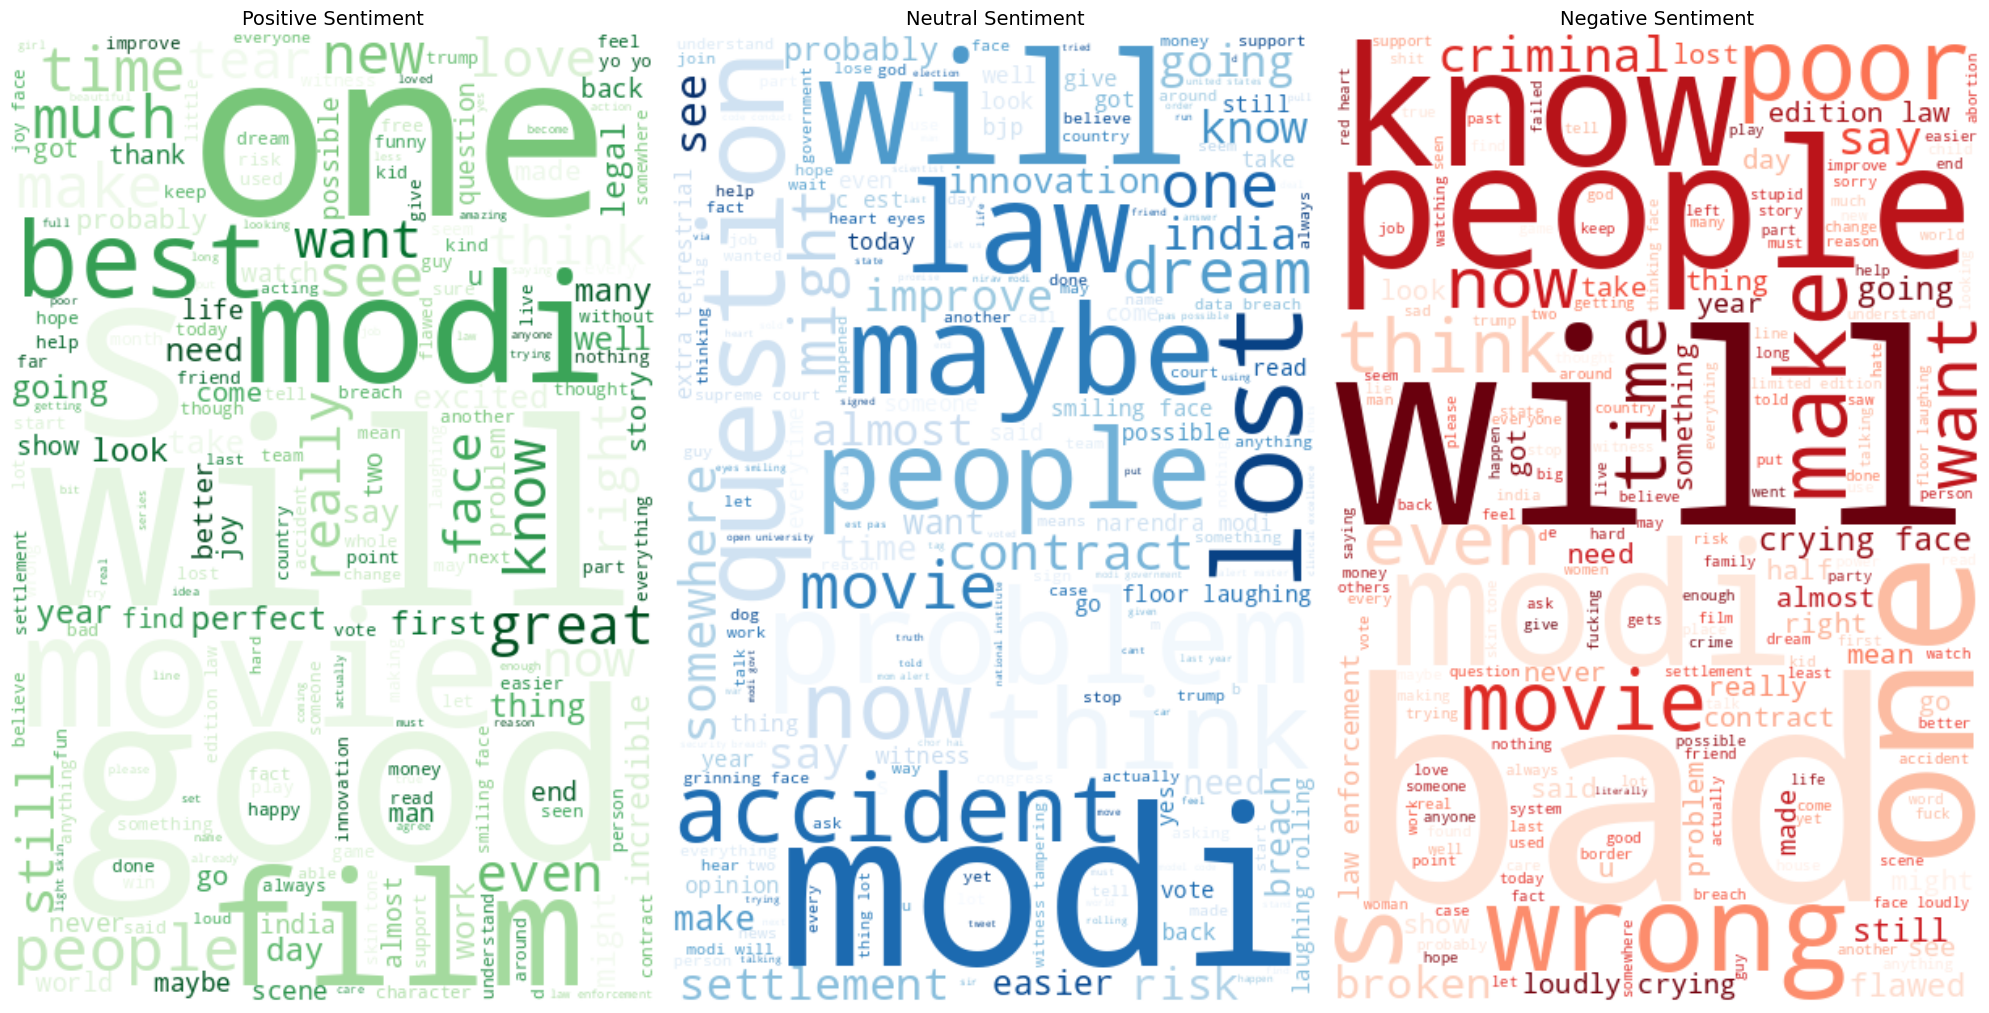

In [28]:
# Create subplots for each sentiment
fig, axes = plt.subplots(1, 3, figsize=(20, 10))


# Define a function to generate word clouds with font colors based on sentiment
def generate_word_cloud(data: pd.Series, title: str, sentiment_color: str, ax: Any):
    """
    Generate a word cloud from text data and display it on a specified axis.

    Args:
        data (pd.Series): The text data from which to generate the word cloud.
        title (str): The title for the word cloud.
        sentiment_color (str): The color map for the word cloud.
        ax: The axis on which to display the word cloud.
    """
    # Combine the text data into a single string
    text_combined = " ".join(data)

    # Customize the WordCloud appearance
    wordcloud = WordCloud(
        width=400,
        height=600,
        background_color="white",
        colormap=sentiment_color,
        contour_color="black",
        contour_width=1,
    ).generate(text_combined)

    # Set the current axis to the specified one
    plt.sca(ax)
    
    # Display the word cloud on the axis
    plt.imshow(wordcloud, interpolation="bilinear")
    
    # Set the title for the word cloud
    plt.title(title, fontsize=14)
    
    # Turn off axis labels and ticks
    plt.axis("off")



generate_word_cloud(
    sample_positive_df['clean_text'], "Positive Sentiment", "Greens", ax=axes[0]
)
generate_word_cloud(
    sample_neutral_df['clean_text'], "Neutral Sentiment", "Blues", ax=axes[1]
)
generate_word_cloud(
    sample_negative_df['clean_text'], "Negative Sentiment", "Reds", ax=axes[2]
)

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

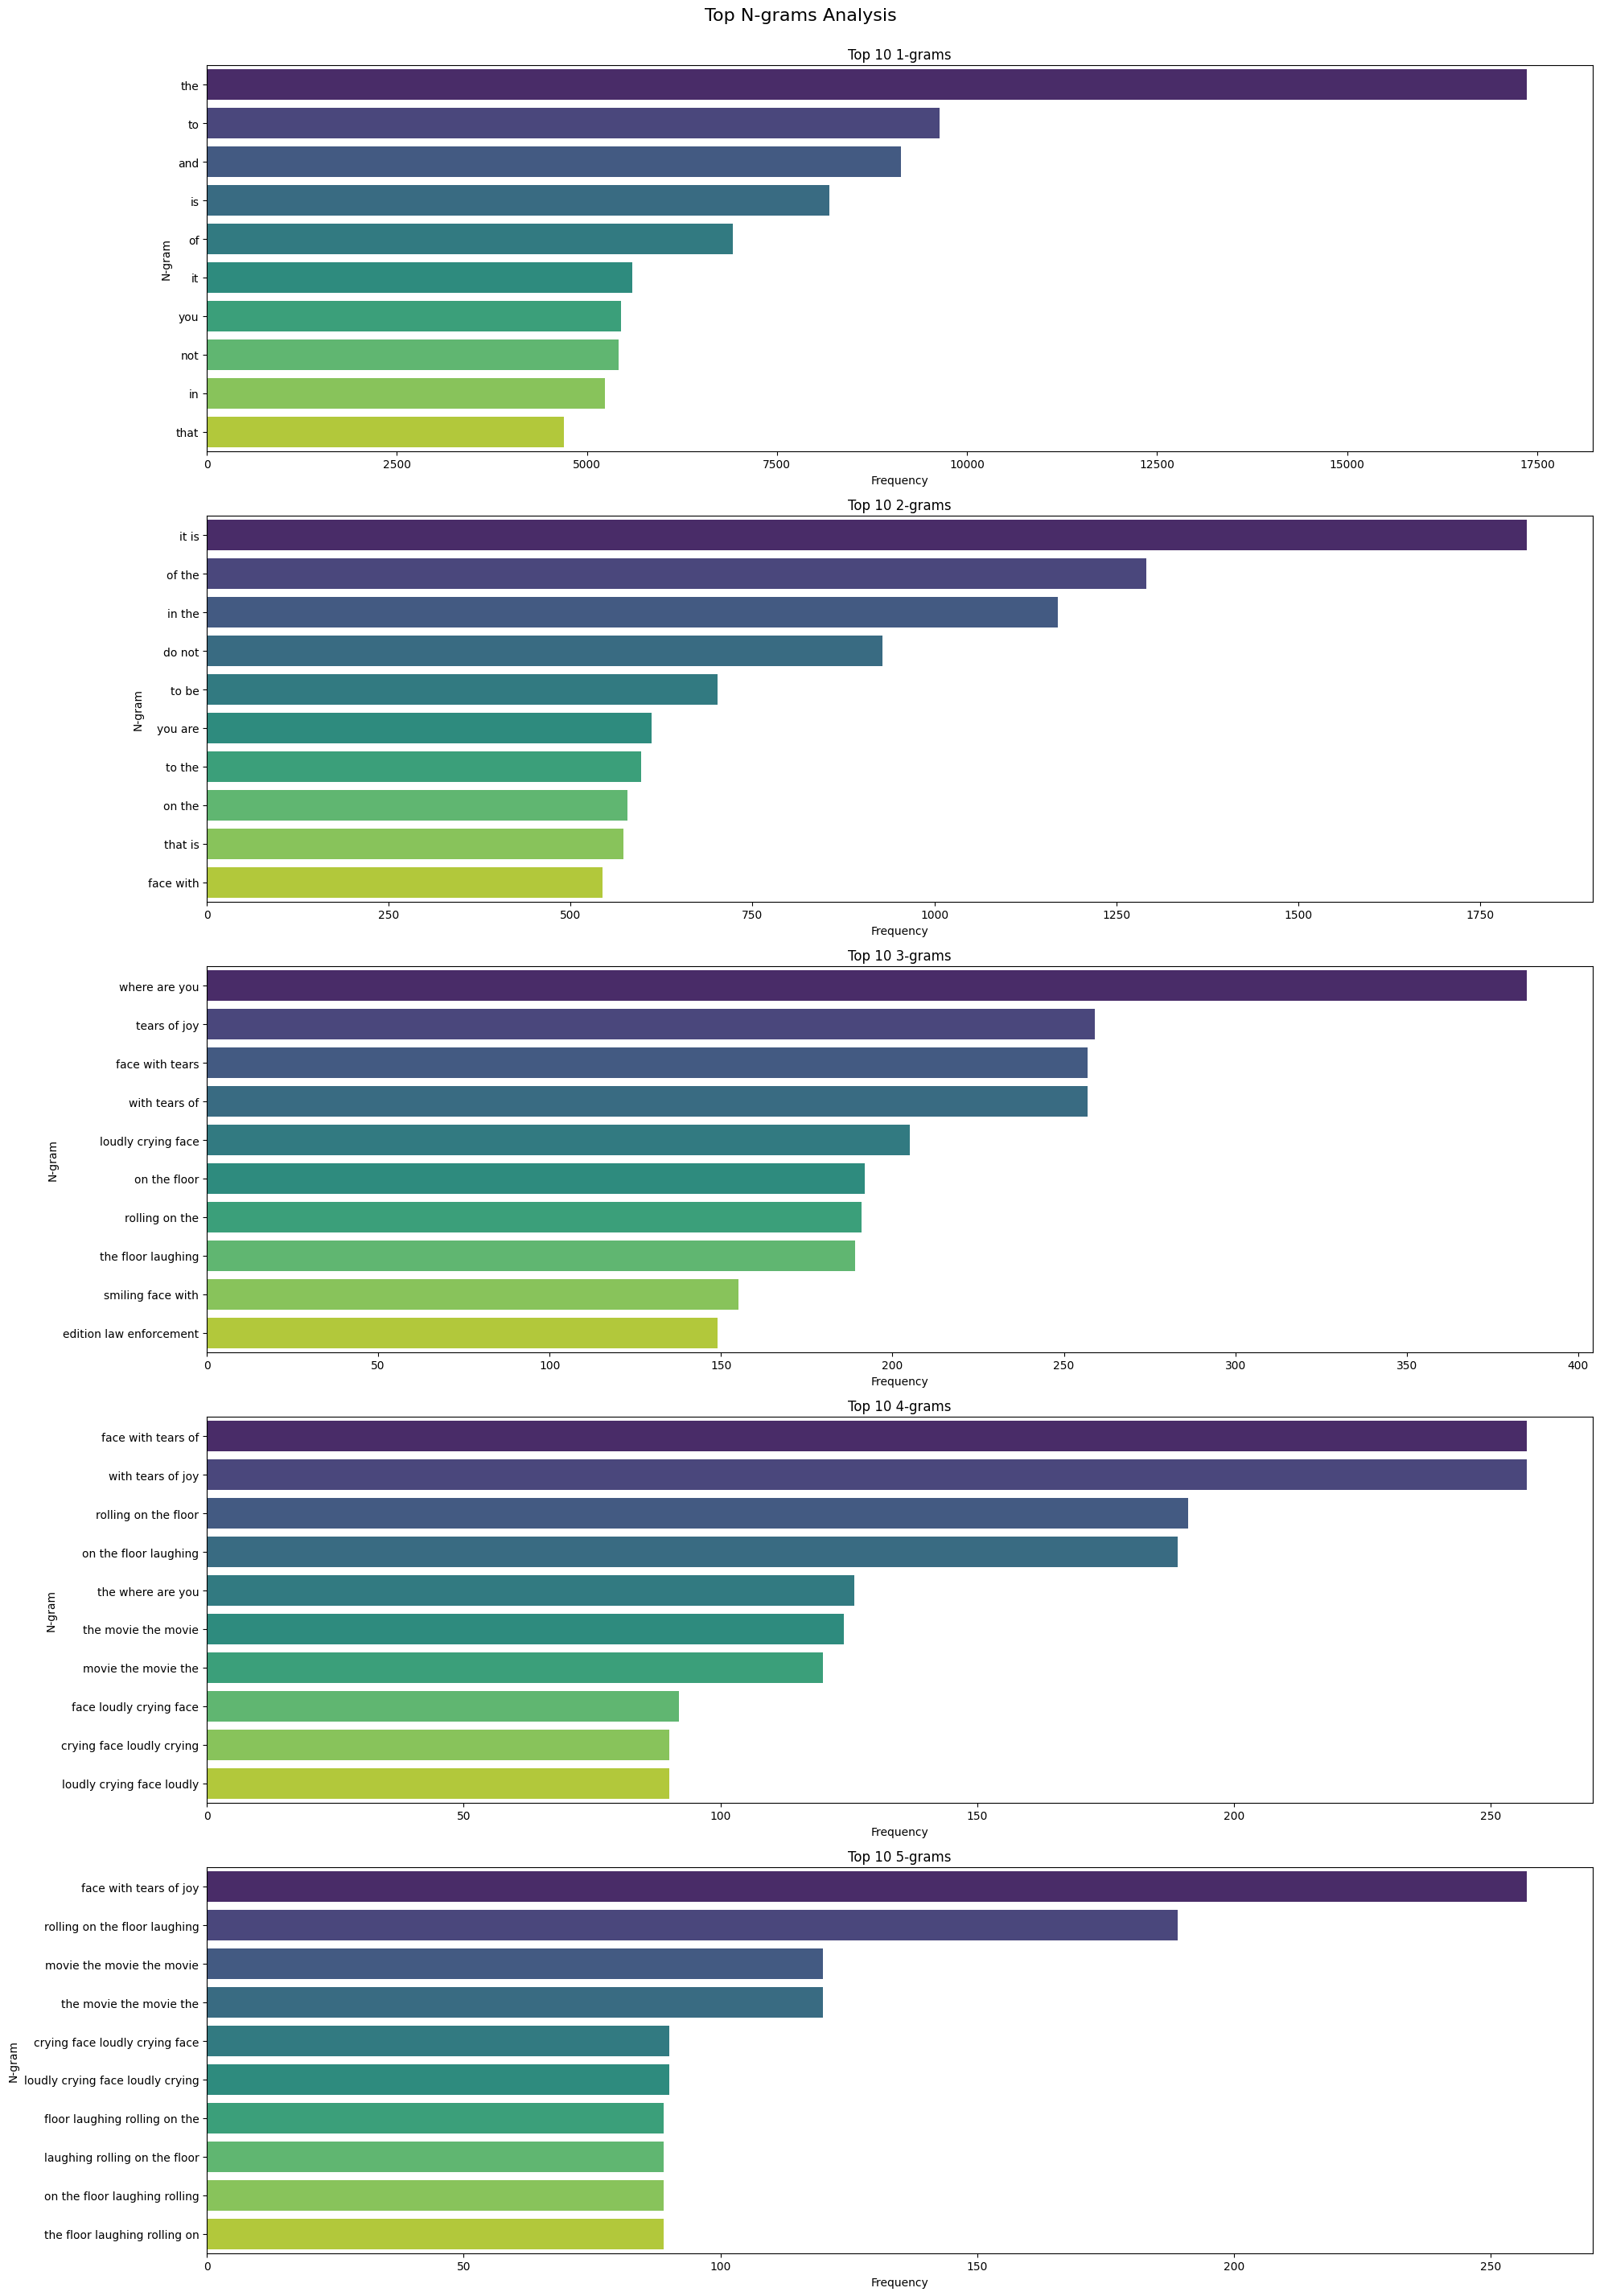

In [30]:
# Create subplots for each sentiment
fig, axes = plt.subplots(5, 1, figsize=(20, 30))

# Set the main title for the entire figure
plt.suptitle("Top N-grams Analysis", fontsize=16)

# Define a function to plot the most common n-grams
def plot_top_ngrams(data, text_column, ax, ngram_range=(2, 2), top_n=10):
    """
    Plot the frequency of the top N n-grams in a text dataset.

    Args:
        data: The DataFrame containing the text data.
        text_column: The name of the column containing the text data.
        ax: The axis on which to plot the n-grams.
        ngram_range: A tuple specifying the range of n-grams (e.g., (2, 2) for bigrams).
        top_n: The number of top n-grams to plot.
    """
    # Extract the text data from the DataFrame
    text_data = data[text_column]
    
    # Create a CountVectorizer to extract n-grams
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(text_data)
    
    # Calculate the frequency of each n-gram
    ngram_freq = zip(
        vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]
    )
    
    # Sort n-grams by frequency and select the top N
    sorted_ngrams = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_n]
    
    # Extract n-gram labels and counts
    ngram_labels, ngram_counts = zip(*sorted_ngrams)
    
    # Create a bar plot to visualize the top N n-grams
    sns.barplot(x=list(ngram_counts), y=list(ngram_labels), palette="viridis", ax=ax)
    
    # Set plot title, labels, and axis
    ax.set_title(f"Top {top_n} {ngram_range[0]}-grams")
    ax.set_xlabel("Frequency")
    ax.set_ylabel("N-gram")


# Plot top bigrams
plot_top_ngrams(
    balance_df, "clean_text", ngram_range=(1, 1), top_n=10, ax=axes[0]
)
plot_top_ngrams(
    balance_df, "clean_text", ngram_range=(2, 2), top_n=10, ax=axes[1]
)
plot_top_ngrams(
    balance_df, "clean_text", ngram_range=(3, 3), top_n=10, ax=axes[2]
)
plot_top_ngrams(
    balance_df, "clean_text", ngram_range=(4, 4), top_n=10, ax=axes[3]
)
plot_top_ngrams(
    balance_df, "clean_text", ngram_range=(5, 5), top_n=10, ax=axes[4]
)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.98])  # Add some space for the main title
plt.show()


In [31]:
balance_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15351 entries, 1158402 to 613903
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   clean_text   15351 non-null  object 
 1   polarity     15351 non-null  float64
 2   sentiment    15351 non-null  object 
 3   text_length  15351 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 599.6+ KB


In [32]:
balance_df['sentiment'].value_counts()

sentiment
positive    5117
neutral     5117
negative    5117
Name: count, dtype: int64

## Data Preprocessing 🧹

We'll perform final data preprocessing steps, including encoding sentiment labels and optimizing data types.

In [33]:
# Drop 'polarity' and 'text_length' columns
balance_df = balance_df.drop(columns=['polarity', 'text_length'])

# Rename 'clear_text' column to 'text'
balance_df = balance_df.rename(columns={'clean_text': 'text'})

# Encode 'sentiment' column
sentiment_encoding = {'positive': 4, 'neutral': 2, 'negative': 0}
balance_df['sentiment'] = balance_df['sentiment'].map(sentiment_encoding)

# Optimize data types
balance_df['sentiment'] = pd.to_numeric(balance_df['sentiment'], downcast='integer')
balance_df['text'] = balance_df['text'].astype('string')

In [34]:
balance_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15351 entries, 1158402 to 613903
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       15351 non-null  string
 1   sentiment  15351 non-null  int8  
dtypes: int8(1), string(1)
memory usage: 254.9 KB


## Saving Processed Data

Saving balance_df data into `sample_dataset.br` file

In [35]:
balance_df.to_parquet('./../data/intermediate_data/sample_dataset.br', engine='pyarrow',compression='brotli', index=False)

## Conclusion 📝

This EDA notebook has provided a deep understanding of the dataset. We've analyzed text sentiment, distribution of text length, top N-grams, and more. The data is now well-prepared for subsequent tasks such as machine learning modeling.

Happy exploring! 📊🔍